# Waveguide Dispersion

In this chapter, we'll explore how to use femwell for more accurate waveguide modeling. Unlike simpler analytical models, FEMWELL allows us to solve Maxwell's equations directly on the waveguide geometry.

Using femwell, you can mesh any component cross-section and solve PDEs with its powerful mode solver. Unlike other solvers that rely on predefined geometries, femwell works directly with the actual component geometry. You can compute the modes of a GDSFactory cross-section, which internally defines a "uz" mesh perpendicular to a straight component using the provided cross-section.

1. import all the necessary packages:


In [1]:
import doModels.RefractiveIndex as ri
from doModels import fem, PhotonicStack
from numpy.polynomial import Polynomial

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


2. Define photonic stack:


In [2]:
stack = PhotonicStack.create(
    total_film_thickness=0.210,
    etch_depth=0.210,
    top_width=0.450,
    side_wall_angle=0,
    top_oxide_thickness=2.0,
    bottom_oxide_thickness=2.0,
)

3. Define simulation paramaters: a range of waveguide widths, wavelength, etc


In [3]:

wavelengths = np.linspace(1.5, 1.6, 50)
num_modes = 2

all_neffs = np.zeros((wavelengths.shape[0], num_modes), dtype=complex)
all_te_fracs = np.zeros((wavelengths.shape[0], num_modes))

4. Run the FEM


In [4]:

m = fem.mesh_waveguide(total_film_thickness=stack.total_film_thickness.target,
    etch_depth=stack.etch_depth.target,
    top_width=stack.top_width.target,
    side_wall_angle=stack.side_wall_angle.target, show_plot=False)

for i, wavelength in enumerate(tqdm(wavelengths)):
    modes = fem.fem_waveguide(mesh=m, n_core=ri.silicon, n_clad=ri.silica, n_box=ri.silica, wavelength=wavelength, num_modes=num_modes)
    all_neffs[i] = [mode.n_eff for mode in modes]
    all_te_fracs[i, :] = [mode.te_fraction for mode in modes]


  0%|          | 0/50 [00:00<?, ?it/s]

We also save the data in xarray's netcdf file. Xarray provides a good multivariable interpolator which we will use later for circuit level simulations.

In [5]:
import xarray as xr

neff_te0 = np.real(all_neffs[:, 0])
neff_tm0 = np.real(all_neffs[:, 1])

xarr = xr.DataArray(
    data=neff_te0, 
    coords={
        "wavelength": wavelengths,
    },
    dims=["wavelength"],
    name="neff_te0"
)

xarr.to_netcdf("data/neff_te0.nc")

5. Plot 


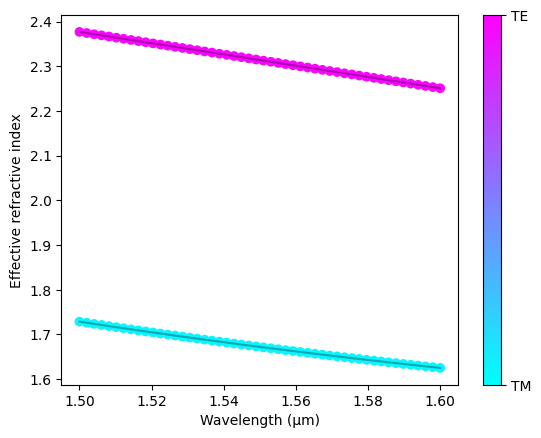

In [6]:
all_neffs = np.real(all_neffs)

plt.figure()
plt.xlabel("Wavelength (µm)")
plt.ylabel("Effective refractive index")
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    plt.plot(wavelengths, lams, color='black', alpha=0.3)
    sc = plt.scatter(wavelengths, lams, c=te_fracs, cmap="cool", vmin=0, vmax=1)
cbar = plt.colorbar(sc)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["TM", "TE"])



## First Order Derivative: $\frac{d n_{\text{eff}}}{d\lambda}$

Compute group index:
$$
n_g = n_{\text{eff}} - \lambda \frac{d n_{\text{eff}}}{d\lambda},
$$

and group velocity:
$$
v_g = \frac{c}{n_g}.
$$

For simpilicity, we only plot this for the TE0 mode.


Group index at 1.55 µm:  4.2677118614710725


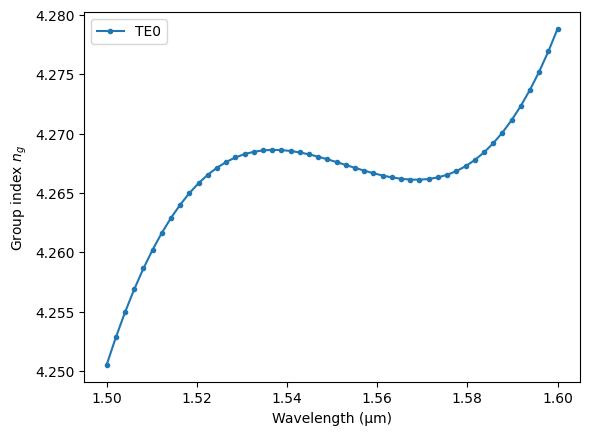

In [7]:

neff_te = all_neffs[:,0]
neff_te_fit = Polynomial.fit(wavelengths, neff_te, deg=4)

# Group index
n_g = neff_te_fit(wavelengths) - wavelengths * neff_te_fit.deriv(1)(wavelengths)

plt.figure()
plt.plot(wavelengths, n_g, '.-', label="TE0")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Group index $n_g$")
plt.legend()

print("Group index at 1.55 µm: ", neff_te_fit(1.55) - 1.55 * neff_te_fit.deriv(1)(1.55))

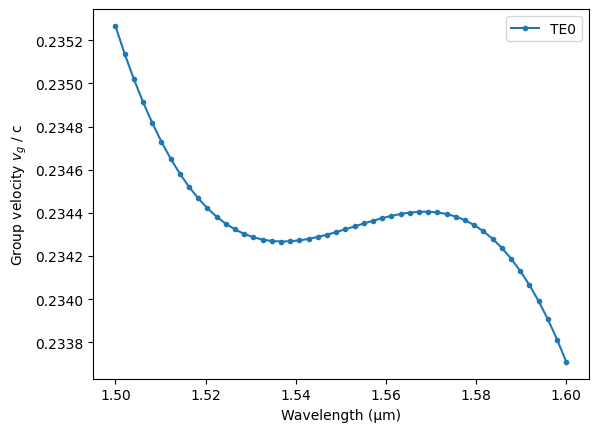

In [8]:

plt.figure()
plt.plot(wavelengths, 1 / n_g, '.-', label="TE0")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Group velocity $v_g$ / c")
plt.legend()



## Second Order Derivative: $\frac{d^2 n_{\text{eff}}}{d\lambda^2}$

Compute group velocity dispersion (GVD) in ps/(nm·km):

$$
D = -\frac{\lambda}{c} \cdot \frac{d^2 n_{\text{eff}}}{d\lambda^2}
$$



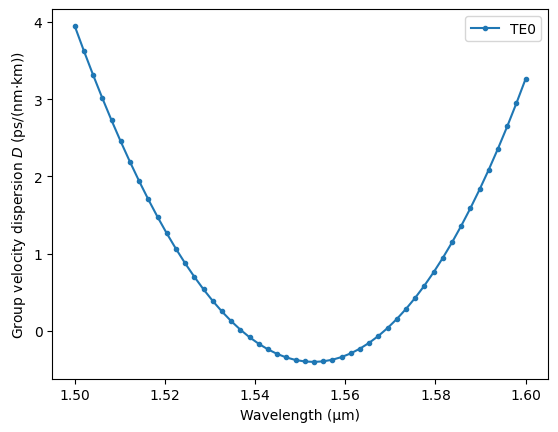

In [9]:

# GVD
c_µm_ps = 299792.458  # speed of light in µm/ps
gvd = -(wavelengths/c_µm_ps) * neff_te_fit.deriv(2)(wavelengths) * 1e6

plt.figure()
plt.plot(wavelengths, gvd, '.-', label="TE0")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Group velocity dispersion $D$ (ps/(nm·km))")
plt.legend()
